In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
artists_df = pd.read_json('data/data_v2/artists.jsonl')
sessions_df = pd.read_json('data/data_v2/sessions.jsonl')
tracks_df = pd.read_json('data/data_v2/tracks.jsonl')
users_df = pd.read_json('data/data_v2/users.jsonl')

Sprawdzamy, czy wszystkie dane są prawidłowe. Jeśli nie, to wiersze z śmieciowymi danymi są usuwane.

In [ ]:
artists_df.isnull().sum()

In [ ]:
sessions_df.isnull().sum()

In [ ]:
tracks_df.isnull().sum()

In [ ]:
users_df.isnull().sum() 

Jedynym zbiorem danych gdzie występowały nulle, jest zbiór sesji. Brakujące dane wynikają z pojawiających się reklam w naszym serwisie. Te dane nie będą nam potrzebne, więc je usuwamy.

In [ ]:
sessions_df.dropna(inplace=True)

Informacje o typach dla kolumn w danych tabelach.

In [ ]:
artists_df.info()

In [ ]:
sessions_df.info()

In [ ]:
tracks_df.info()

In [ ]:
users_df.info()

Wymiarowość danych.

In [ ]:
artists_df.shape

In [ ]:
sessions_df.shape

In [ ]:
tracks_df.shape

In [ ]:
users_df.shape

Podgląd do 10 próbek dla wszystkich zbiorów danych.

In [ ]:
artists_df.head(10)

In [ ]:
sessions_df.head(10)

In [ ]:
tracks_df.head(10)

In [ ]:
users_df.head(10)

Poniżej zamieściłem wykresy z 50 najpopularniejszymi gatunkami wśród artystów i użytkowników.

In [ ]:
popular_genres_artists = (artists_df.explode("genres")
                            ).value_counts("genres")[:50].iloc[::-1]

popular_genres_artists.plot(kind="barh",
                            title ="Most popular artists genres",
                            xlabel="Popularity",
                            ylabel="Genre",
                            figsize=(10,15))

In [ ]:
popular_genres_users = (users_df.explode("favourite_genres")
                          ).value_counts("favourite_genres")[:50].iloc[::-1]

popular_genres_users.plot(kind="barh",
                          title="Most popular users genres",
                          xlabel="Popularity",
                          ylabel="Genre", 
                          figsize=(10,15))

Mapa korelacji pomiędzy wybranymi atrybutami dla utworów.

In [ ]:
df = tracks_df[[
    "duration_ms",
    "danceability", "energy", 
    "loudness", "speechiness", "acousticness", 
    "instrumentalness", "liveness" , "valence", 
    "tempo"]]

f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)

Mapa korelacji liczonej metodą spearmana.

In [ ]:
df = tracks_df.drop(columns=[
    "id",
    "name",
    "explicit",
    "id_artist",
    "release_date"
])

f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr(method='spearman')
sns.heatmap(corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)

Wykres kołowy przedstawiający procent użytkowników premium.

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
users_df["premium_user"].value_counts().plot(kind="pie", 
                                             title="User account type",
                                             ax = ax,
                                             labels=None,
                                             autopct='%1.1f%%',
                                             )

ax.legend(loc=3, labels=["Standard", "Premium"])
plt.show()

Wykres przedstawiający 30 najczęściej pojawiających się utworów w sesjach.

In [ ]:
track_popularity = sessions_df[
    sessions_df["event_type"] == "play"
  ].value_counts("track_id").rename_axis('id').reset_index(name='counts')

track_popularity = track_popularity.merge(tracks_df, 
                       left_on="id", 
                       right_on="id")[["name", "counts"]][:30].iloc[::-1]

track_popularity.plot(kind="barh",
                        x = "name",
                        y = "counts",
                        title="Most popular track from sessions",
                        xlabel="Popularity",
                        ylabel="Title", 
                        figsize=(10,15))

Sprawdziliśmy jak liczba występień poszczególnych utworów koreluje z atrybutem popularity. Dla aktualnych danych współczynnik korelacji wynosi -0.008789, a więc atrybut nie wydaje się być skorelowany z realną popularnością.

In [ ]:
track_popularity = sessions_df[
    sessions_df["event_type"] == "play"
  ].value_counts("track_id").rename_axis('id').reset_index(name='counts')
track_popularity = track_popularity.merge(tracks_df, 
                       left_on="id", 
                       right_on="id")[["popularity", "counts"]]
track_popularity.corr()

Wykres słupkowy dla utworów powstałych w danym roku.

In [ ]:
series = tracks_df["release_date"].map(lambda x: x[:4]).astype({"release_date" : int}).value_counts()
df = pd.DataFrame()
df["year"] = series.index
df["count"] = series.values

df.sort_values(by=["year"]).plot(
    x="year",
    y="count",
    kind="barh",
    legend=None,
    figsize=(10,15),
    title="Tracks per year",
    xlabel="count",
    ylabel="year"
)

Ruch w serwisie z podziałem na dni tygodnia.

In [ ]:
series = sessions_df.groupby("session_id").first()["timestamp"].map(lambda x: x.strftime('%A')).value_counts()

df = pd.DataFrame()
df["day"] = series.index
df["count"] = series.values

cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df['day'] = pd.Categorical(df['day'], categories=cats, ordered=True)
df.sort_values(by=["day"]).plot(
    x="day",
    y="count",
    kind = "bar",
    legend=False,
    title="Number sessions per day.",
    xlabel="day",
    ylabel="sessions number"
)

Testy, czy zmienne niosą informacje o funkcji celu

In [5]:
def test_model(model,columns):
    counter = 0
    for session_id,row in sessions_df.groupby("session_id").first().iterrows():
        track = tracks_df[tracks_df['id'] == row['track_id']]
        x = track[columns]
        preds = model.predict(x)
        session_tracks = sessions_df[sessions_df['session_id'] == session_id].iloc[1:]['track_id']
        session_tracks = session_tracks[session_tracks.notnull()]
        for track in session_tracks:
            if track in preds:
                counter += 1
    return counter
        

    

In [6]:
column_list = ['popularity','duration_ms','explicit','danceability',
               'energy','key','loudness','speechiness',
                'acousticness', 'liveness','valence','tempo']
import random
df = pd.DataFrame(-1, index=column_list, columns=column_list)

In [10]:
from sklearn.neighbors import KNeighborsClassifier

for column1 in column_list:
    for column2 in column_list:
        if df.at[column1,column2] == -1:
            columns = [column1] if column1 == column2 else [column1,column2]
            x = tracks_df[columns]
            y = tracks_df['id']
            knn = KNeighborsClassifier(n_neighbors=20)
            knn.fit(x,y)
            result = test_model(knn,columns)
            df.at[column1,column2] = result
            df.at[column2,column1] = result

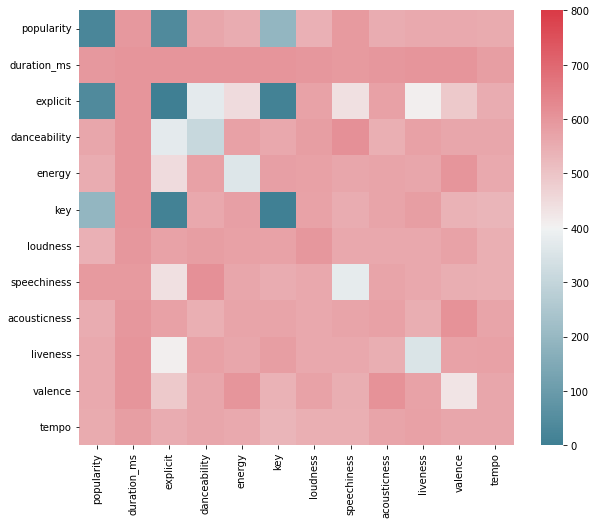

In [18]:
f, ax = plt.subplots(figsize=(10, 8))
heat = sns.heatmap(df,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=0, vmax=800.0,
    square=True, ax=ax)
fig = heat.figure
fig.savefig('heatmap.png')